In [1]:
import time

import numpy as np
import cv2
from imutils import face_utils
import dlib
from face import FacePoints
from tracking import TrackPoints
from tqdm import tqdm
#from tqdm.notebook import tqdm

import matplotlib.pyplot as plt


In [2]:
def draw_str(dst, target, s):
    x, y = target
    cv2.putText(dst, s, (x+1, y+1), cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 0), thickness = 2, lineType=cv2.LINE_AA)
    cv2.putText(dst, s, (x, y), cv2.FONT_HERSHEY_PLAIN, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)


In [27]:
capture = cv2.VideoCapture('./data/face_videos/standing2.mp4')
fps = int(capture.get(cv2.CAP_PROP_FPS))
frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
print('fps', fps, 'frame count', frame_count)


fps 16 frame count 356


In [29]:
gray_frames = [] #0 is newest -1 is oldest
#frame_c = 0

face = FacePoints()
tracking = TrackPoints(max_trace_history=600)

# Create some random colors
color = np.random.randint(0,255,(100,3))

gray = None
vis = None

#while capture.isOpened():
for frame_c in tqdm(range(frame_count)):
    # getting a frame
    ret, frame = capture.read()
    if not ret:
        print('err at', frame_c)
        continue

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    vis = frame.copy()

    gray_frames.insert(0, gray)

    # Wait 5 frames before selecting points
    if frame_c >= 5:
        gray_frames.pop()
        
        tracking.track_points(gray_frames[1], gray_frames[0])

    #frame_c += 1

capture.release()


100%|██████████| 356/356 [00:00<00:00, 6842.57it/s]

err at 0
err at 1
err at 2
err at 3
err at 4
err at 5
err at 6
err at 7
err at 8
err at 9
err at 10
err at 11
err at 12
err at 13
err at 14
err at 15
err at 16
err at 17
err at 18
err at 19
err at 20
err at 21
err at 22
err at 23
err at 24
err at 25
err at 26
err at 27
err at 28
err at 29
err at 30
err at 31
err at 32
err at 33
err at 34
err at 35
err at 36
err at 37
err at 38
err at 39
err at 40
err at 41
err at 42
err at 43
err at 44
err at 45
err at 46
err at 47
err at 48
err at 49
err at 50
err at 51
err at 52
err at 53
err at 54
err at 55
err at 56
err at 57
err at 58
err at 59
err at 60
err at 61
err at 62
err at 63
err at 64
err at 65
err at 66
err at 67
err at 68
err at 69
err at 70
err at 71
err at 72
err at 73
err at 74
err at 75
err at 76
err at 77
err at 78
err at 79
err at 80
err at 81
err at 82
err at 83
err at 84
err at 85
err at 86
err at 87
err at 88
err at 89
err at 90
err at 91
err at 92
err at 93
err at 94
err at 95
err at 96
err at 97
err at 98
err at 99
err at 100

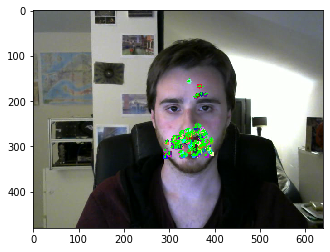

In [5]:
# Plot inline
%matplotlib inline

nextPts = tracking.get_current_points()

# Draw points
for i, new in enumerate(nextPts):
    a,b = new.ravel()
    vis = cv2.circle(vis,(a,b),5,color[i%100].tolist(),-1)

# Draw Tracks
cv2.polylines(vis, [np.int32(tr) for tr in tracking.traces], False, (0, 255, 0))

# The important part - Correct BGR to RGB chann            all_tracks = tracking.traces
el
img = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)

# Plot
plt.imshow(img)
            all_tracks = tracking.traces

# Calculate distance travalled by tracks
#all_tracks = tracking.traces


In [6]:
# Filter traces get 4sec or long nyquist freq for 0.5 hz -> 1 hZ
#traces = [trace for trace in tracking.traces if len(trace) > 4*fps]
trace_max_len = max( [len(trace) for trace in tracking.traces] )
#TODO: This is quickfix
traces = [trace for trace in tracking.traces if len(trace) == trace_max_len]

In [7]:
#traces[-1]

In [8]:
# Calculate y movement of each
displacements = []
#displacements = np.array([[]])
for trace in reversed(traces):
    trace = np.array(trace)

    y_pts = trace[:, 1]
    # Pad array to standart lenght
    len_diff = trace_max_len-len(y_pts)
    if len_diff > 0:
        print('Padded', len_diff)    
    y_pts = np.pad(y_pts, (len_diff, 0), 'edge')
    
    displace = np.diff(y_pts) # y coordinates
    displacements.append(displace)
    #displacements = np.concatenate((displacements, displace), axis=0)
    
#     t = np.arange(len(displace))/fps
#     plt.plot(t, displace)

#     plt.grid()
#     plt.xlabel('Frame')
#     plt.ylabel('Displacement')

#     plt.show()

In [9]:
displacements = np.stack(displacements, axis=0)

## Get FFT and filter



In [10]:
from scipy import interpolate, signal, optimize
from scipy.fftpack import fft, ifft, fftfreq, fftshift

plt.rcParams['figure.figsize'] = [10, 5]

In [11]:
# for i, signal_data in enumerate(displacements):

#     #signal_data = displacements[15]
#     print('Signal:', i)

#     fs = 30 # Fps
#     # number of signal points
#     N = len(signal_data)
#     # sample spacing
#     T = 1.0 / fs

#     #Draw signal
#     #t = np.arange(len(displace))/fps
#     t = np.linspace(0.0, T*N, N)


#     # Filter signal
#     fc = np.array([0.75, 2.])  # Cut-off frequency of the filter
#     # 0.75 hz - 2 hz => 45bpm - 120bpm

#     w = fc / (fs / 2) # Normalize the frequency
#     b, a = signal.butter(5, w, 'bandpass')

#     filter_output = signal.filtfilt(b, a, signal_data)


#     # Show FFT
#     # Draw pre and after FFT

#     pre_yf = fft(signal_data)
#     pre_xf = fftfreq(N, T)
#     pre_xf = fftshift(pre_xf)
#     pre_yf = fftshift(pre_yf)

#     after_yf = fft(filter_output)
#     after_xf = fftfreq(N, T)
#     after_xf = fftshift(after_xf)
#     after_yf = fftshift(after_yf)

#     # Draw
#     fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
#     fig.suptitle('Filter')

#     ax1.plot(t, signal_data)
#     ax1.set_title('Pre Filtered')
#     ax1.grid()
#     ax1.set(xlabel='Time', ylabel='Pixel movement')

#     ax2.plot(t, filter_output)
#     ax2.set_title('After Filtered')
#     ax2.grid()
#     ax2.set(xlabel='Time', ylabel='Pixel movement')

#     plt.show()

#     # Draw
#     fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
#     fig.suptitle('Filter')

#     ax1.plot(pre_xf, 1.0/N * np.abs(pre_yf))
#     ax1.set_title('Pre Filtered')
#     ax1.grid()
#     ax1.set(xlabel='Freq', ylabel='')

#     ax2.plot(after_xf, 1.0/N * np.abs(after_yf))
#     ax2.set_title('After Filtered')
#     ax2.grid()
#     ax2.set(xlabel='Freq', ylabel='')


#     plt.grid()
#     plt.show()


In [20]:
# Filter Signal
def filter_signal(signal_data, fs=30, low_c=0.75, high_c=2.0):

    #fs = 30 # Fps
    # number of signal points
    N = len(signal_data)
    # sample spacing
    T = 1.0 / fs

    #Draw signal
    #t = np.arange(len(displace))/fps
    t = np.linspace(0.0, T*N, N)

    # Filter signal
    fc = np.array([low_c, high_c])  # Cut-off frequency of the filter
    # 0.75 hz - 2 hz => 45bpm - 120bpm

    w = fc / (fs / 2) # Normalize the frequency
    b, a = signal.butter(5, w, 'bandpass')

    filter_output = signal.filtfilt(b, a, signal_data)
    
    return filter_output

filtered_signals = []

for signal_data in displacements:
    filter_out = filter_signal(signal_data, fs=fps)
    filtered_signals.append(filter_out)

filtered_signals = np.stack(filtered_signals, axis=0)

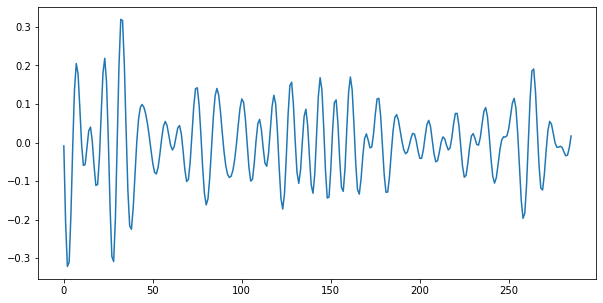

In [21]:
plt.plot(filtered_signals[85])

## DO PCA

In [22]:
from sklearn.decomposition import PCA
filtered_signals.shape

(91, 286)

In [23]:
#filtered_signals

pca = PCA(n_components=5)
pca_result = pca.fit_transform(filtered_signals.T).T
pca_result.shape

(5, 286)

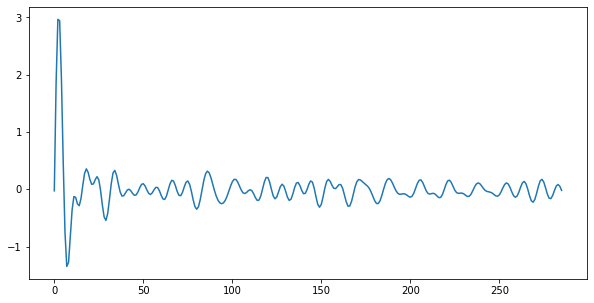

In [24]:
plt.plot(pca_result[1])

In [18]:
#pca_result.explained_variance_ratio_

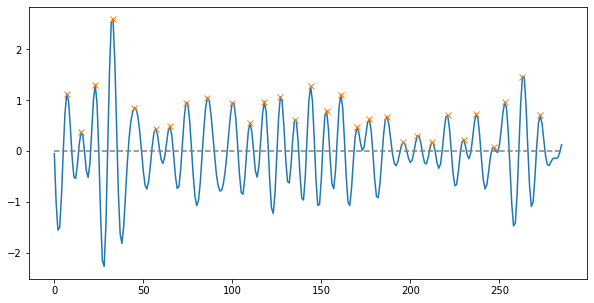

94.40559440559441


In [25]:
from scipy.signal import find_peaks

x = pca_result[0]
peaks, _ = find_peaks(x, height=0)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

total_secs = len(x)/fps
total_beats = len(peaks)
bps = total_beats / total_secs

print(bps*60)